<h1 > House Price Prediction using Regularization techniques</h1>

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia.  The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not. 

The company wants to know:
- Which variables are significant in predicting the price of a house
- How well those variables describe the price of a house.


In [1]:
# Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
## Setting certain variables for the program.
seed = 42
filterwarnings('ignore')

Custom Functions

In [3]:
# Removing redundant features:
def redundant_features(master):
    redundants = []
    for i in master.columns:
        counts = master[i].value_counts()
        count_max = counts.iloc[0]
        if count_max / len(master) * 100 > 98: # if there is one value more than 98% in the entire dataset i.e. biased.
            redundants.append(i)
    redundants = list(redundants)
    return redundants

def drop_outliers(x):    
    for col in outl_col:
        Q1 = x[col].quantile(.25)
        Q3 = x[col].quantile(.99)
        IQR = Q3-Q1
        x =  x[(x[col] >= (Q1-(1.5*IQR))) & (x[col] <= (Q3+(1.5*IQR)))] 
    return x  

In [4]:
master = pd.read_csv("train.csv")
master = master.drop(["Id"],axis=1)
print(master.shape)
master.head()

(1460, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
## Checking Missing Data
master.isna().sum()

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 80, dtype: int64

In [6]:
master.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## Data Cleaning

In [7]:
# Checking the percentage of Null values in all the columns
print('Percentage of Missing Values in each column is as follows:')
print(round(master.isnull().sum()/len(master.index)*100,2).sort_values(ascending=False)[ round(master.isnull().sum()/len(master.index),2) > 0 ] )

Percentage of Missing Values in each column is as follows:
PoolQC          99.52
MiscFeature     96.30
Alley           93.77
Fence           80.75
FireplaceQu     47.26
LotFrontage     17.74
GarageYrBlt      5.55
GarageCond       5.55
GarageType       5.55
GarageFinish     5.55
GarageQual       5.55
BsmtExposure     2.60
BsmtFinType2     2.60
BsmtCond         2.53
BsmtQual         2.53
BsmtFinType1     2.53
MasVnrArea       0.55
MasVnrType       0.55
dtype: float64


<b>Obs</b>:</br>
5 features have large number missing values. Keeping a <b> arbitary threshold value of 80%</b>, the top four columns are removed.

In [8]:
cols_drop = ["PoolQC","MiscFeature","Alley","Fence"]
master = master.drop(cols_drop,axis=1)
master.shape

(1460, 76)

In [9]:
# Some columns have numerical values but have categorical meanings. Thus these needs to be ordered into categorical data type.
cols_cat = ["MSSubClass","OverallQual","OverallCond","MoSold"]

for col in cols_cat:
    master[col] = master[col].astype('category')

### Imputing the missing data with assumptions:

In [10]:
master['FireplaceQu'] = master['FireplaceQu'].fillna('No_Fireplace')
master['GarageYrBlt'] = master['GarageYrBlt'].fillna(0)
master['MasVnrType'] = master['MasVnrType'].fillna('None')
master['MasVnrArea'] = master['MasVnrArea'].fillna(0)
master['MasVnrArea'] = master['MasVnrArea'].fillna(0)

#NA = No Garage (assumed)
master['GarageCond'] = master['GarageCond'].fillna('None')
master['GarageType'] = master['GarageType'].fillna('None')
master['GarageFinish'] = master['GarageFinish'].fillna('None')
master['GarageQual'] = master['GarageQual'].fillna('None')  

#NA = No Basement (assumed)
master['BsmtExposure'] = master['BsmtExposure'].fillna('None')
master['BsmtFinType2'] = master['BsmtFinType2'].fillna('None')
master['BsmtCond'] = master['BsmtCond'].fillna('None')
master['BsmtQual'] = master['BsmtQual'].fillna('None')
master['BsmtFinType1'] = master['BsmtFinType1'].fillna('None')

#LotFrontage : Replacing Null value with the median of the neighbourhood
master['LotFrontage'] = master.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# Filling the Electrical rows with the mode
master['Electrical'] = master['Electrical'].fillna(master['Electrical'].mode()[0])

## Exploratory Data Analysis:

Categorical Features vs Sales Price

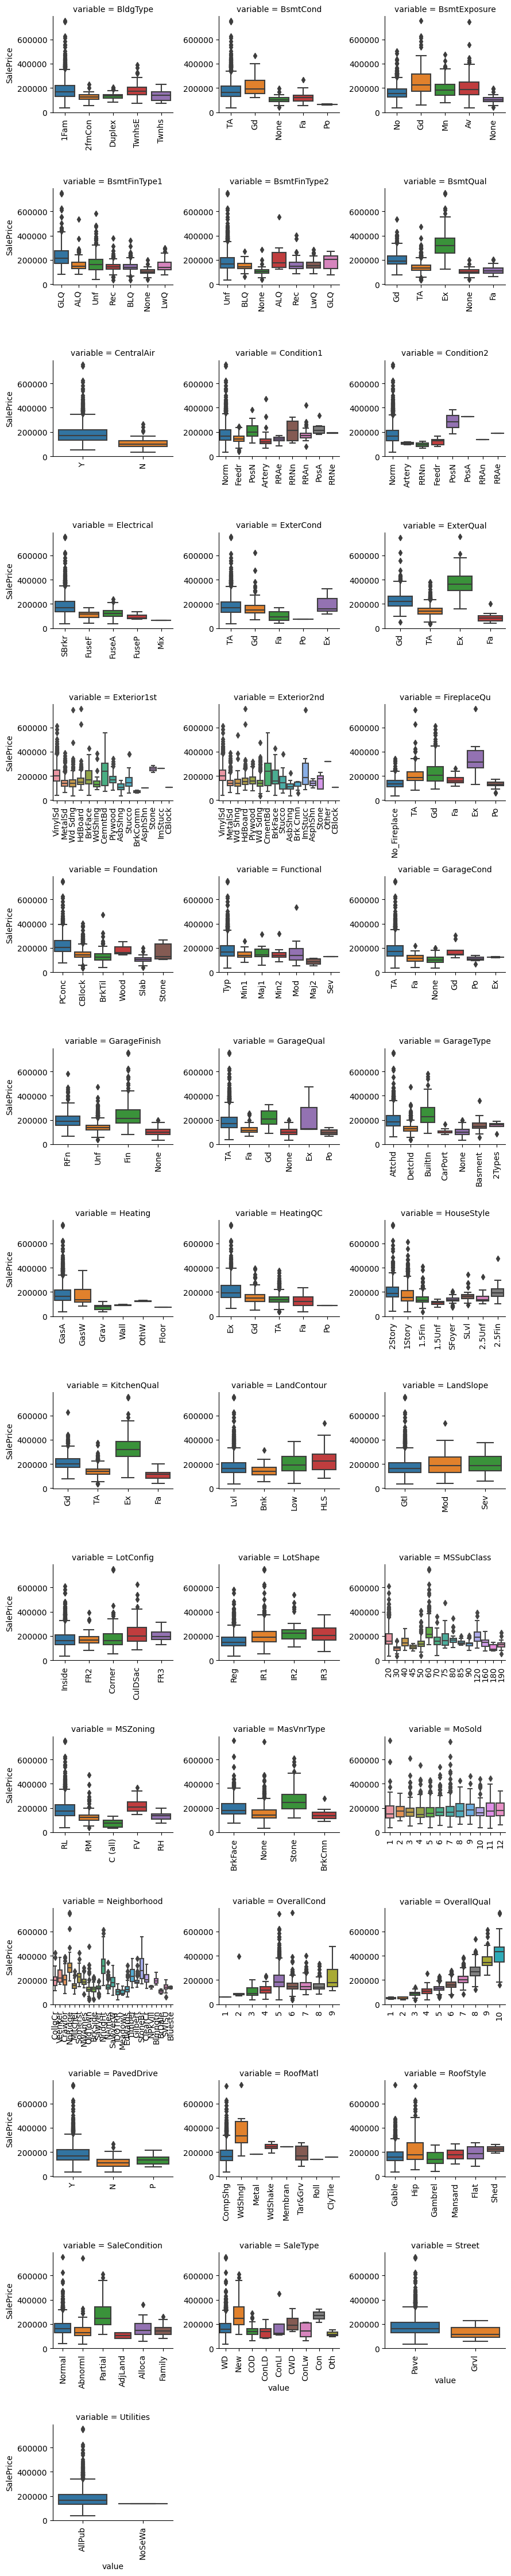

In [11]:
# Plotting Categorical Features with Sale Price
def facetgrid_boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
    
categorical = master.select_dtypes(exclude=['int64','float64'])
f = pd.melt(master, id_vars=['SalePrice'], value_vars=sorted(master[categorical.columns]))
g = sns.FacetGrid(f, col="variable", col_wrap=3, sharex=False, sharey=False)
g = g.map(facetgrid_boxplot, "value", "SalePrice")

Some of the observations from above plot:
- Paved alleys properties has higher price.
- Houses where the basement quality is good and excellent are sold at higher prices.
- Houses with good and excellent garages are sold at higher prices.
- Houses with good quality kitchens has better prices.
- Houses with gas heating has good prices as well.

In [12]:
# Creating a dataframe of numerical features:
master_num = master.select_dtypes(include=['int64','float64'])
master_num.columns

Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'YrSold', 'SalePrice'],
      dtype='object')

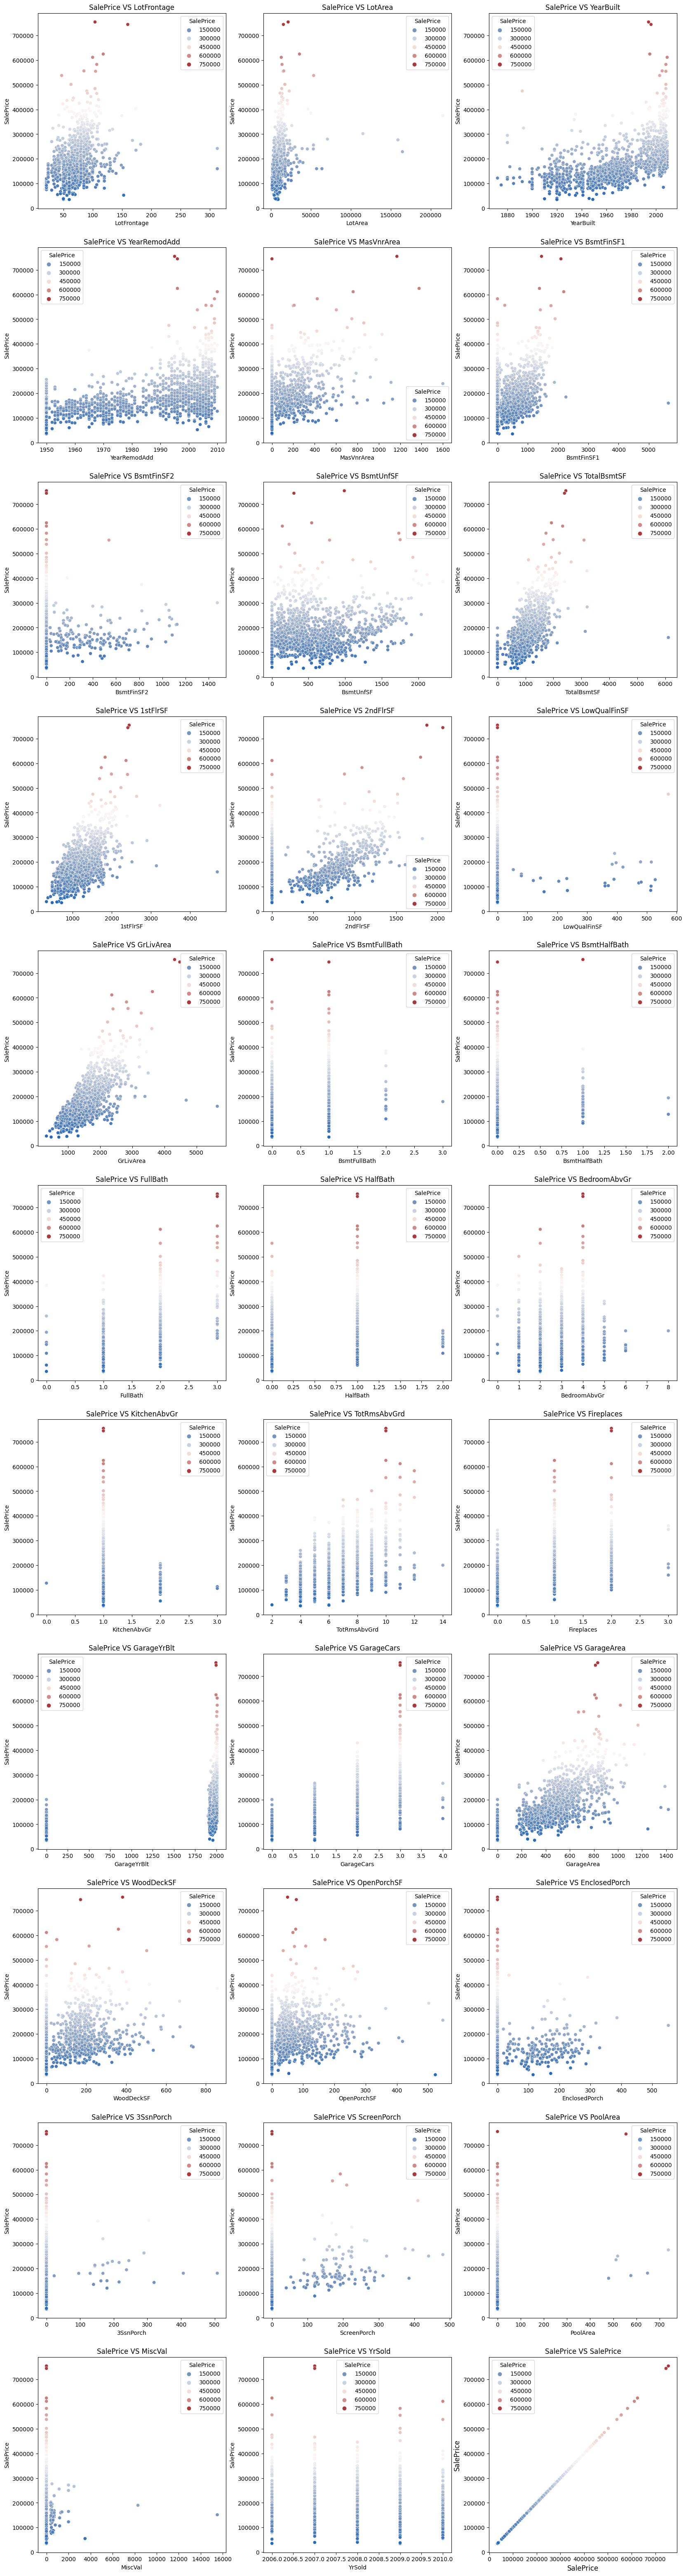

In [13]:
#Visualising numerical predictor variables with Target Variables
fig,axs= plt.subplots(11,3,figsize=(20,80))
for i,ax in zip(master_num.columns,axs.flatten()):
    sns.scatterplot(x=i, y='SalePrice', hue='SalePrice',data=master_num,ax=ax,palette='vlag')
    plt.xlabel(i,fontsize=12)
    plt.ylabel('SalePrice',fontsize=12)
    ax.set_title('SalePrice'+' VS '+str(i))

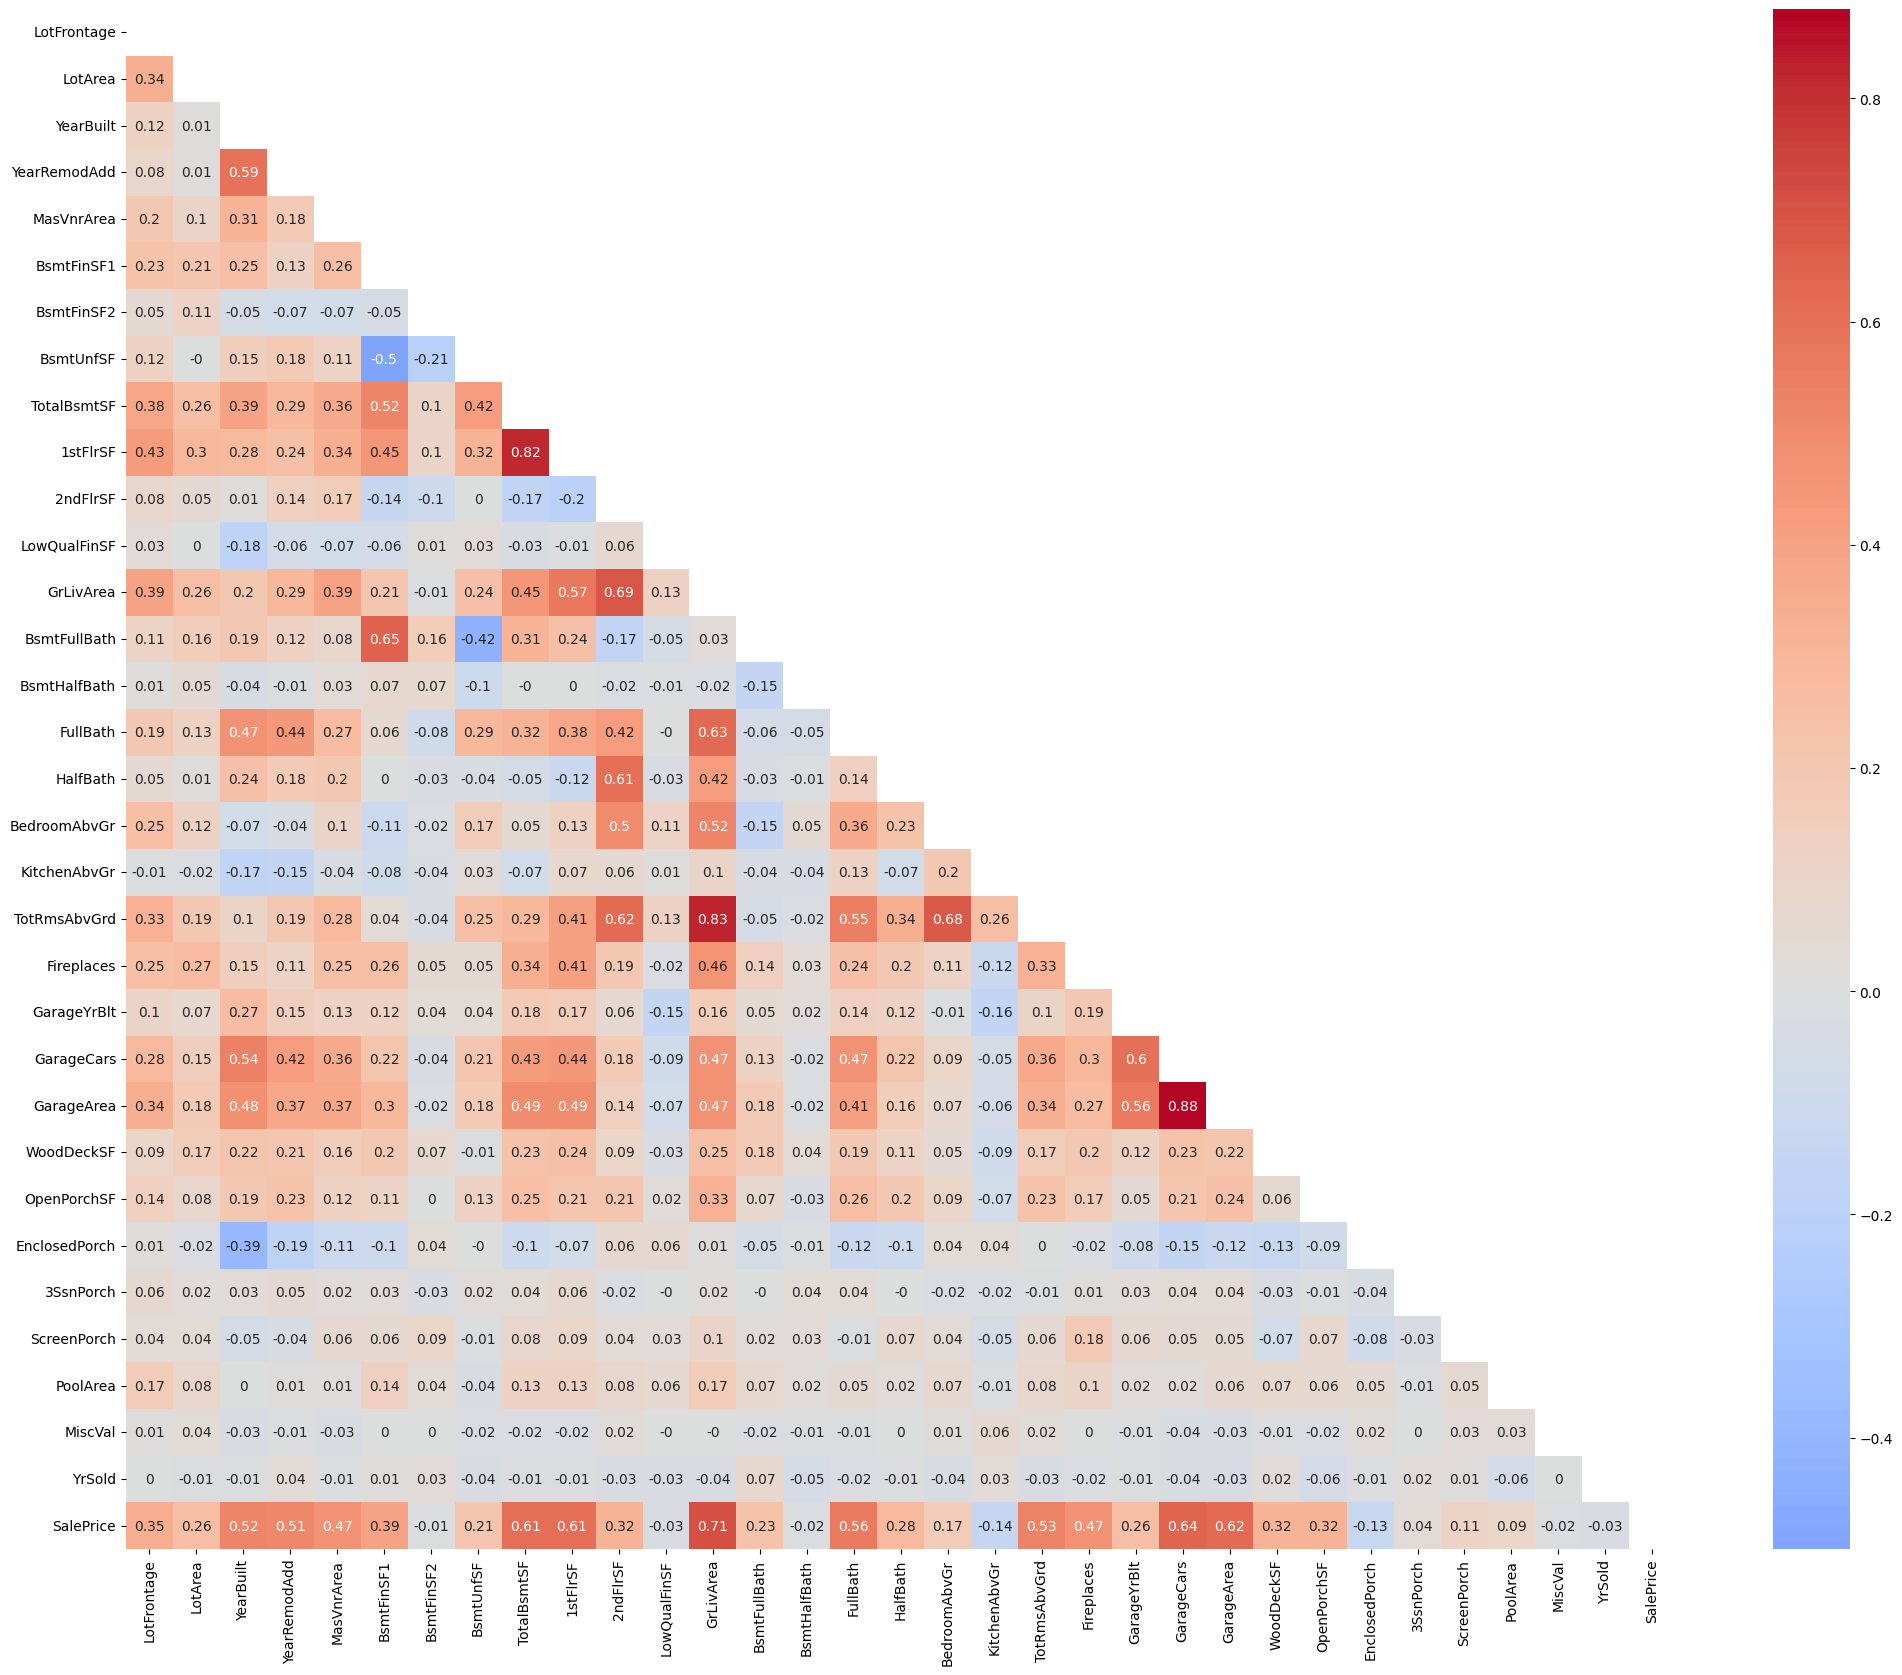

In [14]:
#Plotting heatmap of numerical features
plt.subplots(figsize = (25,20))
corr = master_num.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(round(corr,2), cmap='coolwarm' ,mask=mask, annot=True, center = 0)
plt.show()

## Data Preparation

In [15]:
print(round(master.isnull().sum()/len(master.index)*100,2).sort_values(ascending=False)[round(master.isnull().sum()/len(master.index),2) > 0 ] )

Series([], dtype: float64)


## Feature Engineering

While doing EDA, it was noticed that certain categorical features represented over 95% of the dataset. This bias will not help in proper modelling. Thus it is optimal that these features be removed. <br>

While testing out the function it was noticed that 95% gave out 10 features whereas 98 % gave 6  features to remove. <br>

Thus it was arbitarily decided to use 98% as threshold. <br>

In [16]:
redundant_features = redundant_features(master)
print(redundant_features)

['Street', 'Utilities', 'Condition2', 'RoofMatl', 'LowQualFinSF', '3SsnPorch', 'PoolArea']


In [17]:
master = master.drop(redundant_features,axis=1)
master.shape

(1460, 69)

Handling Outliers

In [18]:
# From EDA it was seen that Living Area, Garage Area, Basement Area and Lot Area. Removing outliers from these. Other outliers will be handled  during power transform.
outl_col = ['GrLivArea','GarageArea','TotalBsmtSF','LotArea'] 
master = drop_outliers(master)
master.shape

(1455, 69)

In [19]:
#Creating some new features based on the existing features

master['YrBltAndRemod']=master['YearBuilt']+master['YearRemodAdd']

# Overall area:
master['Total_sqr_footage'] = (master['BsmtFinSF1'] + master['BsmtFinSF2'] + master['1stFlrSF'] + master['2ndFlrSF'])

# Total number of bathrooms:
master['Total_Bathrooms'] = (master['FullBath'] + (0.5 * master['HalfBath']) + master['BsmtFullBath'] + (0.5 * master['BsmtHalfBath']))

# Total porch area 
master['Total_porch_sf'] = (master['OpenPorchSF'] + master['EnclosedPorch'] + master['ScreenPorch'] + master['WoodDeckSF'])

In [20]:
master.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,YrBltAndRemod,Total_sqr_footage,Total_Bathrooms,Total_porch_sf
0,60,RL,65.0,8450,Reg,Lvl,Inside,Gtl,CollgCr,Norm,...,0,2,2008,WD,Normal,208500,4006,2416,3.5,61
1,20,RL,80.0,9600,Reg,Lvl,FR2,Gtl,Veenker,Feedr,...,0,5,2007,WD,Normal,181500,3952,2240,2.5,298
2,60,RL,68.0,11250,IR1,Lvl,Inside,Gtl,CollgCr,Norm,...,0,9,2008,WD,Normal,223500,4003,2272,3.5,42
3,70,RL,60.0,9550,IR1,Lvl,Corner,Gtl,Crawfor,Norm,...,0,2,2006,WD,Abnorml,140000,3885,1933,2.0,307
4,60,RL,84.0,14260,IR1,Lvl,FR2,Gtl,NoRidge,Norm,...,0,12,2008,WD,Normal,250000,4000,2853,3.5,276


---

## Data Modelling:

Creation of Dummy Variables

In [21]:
#Creating Dummy Variables for Categorical Columns
num_col=[]
cat_col=[]

for i in master.columns:
    if master[i].dtypes in ["int64","float64"]:
        num_col.append(i)
    else:
        cat_col.append(i)
df = pd.get_dummies(master[cat_col],drop_first=True)
master=pd.concat([master,df],axis=1)
master= master.drop(cat_col,axis=1)        

In [22]:
# Predictor Variables:
X = master.drop('SalePrice',axis=1)

# Target Variable
y = master['SalePrice']

In [23]:
# Correlation coefficient threshold is arbitarily taken  as 0.7
threshold  = 0.7

# Checking co-related features
corr = X.corr()

corr1 = corr[abs(corr)>= threshold] 
corr2 =  corr.where(~np.tril(np.ones(corr.shape)).astype(np.bool))  #To remove repetition and 1 correlations

corr_result = corr2.stack()
print(corr_result[(abs(corr_result) > threshold)])

YearBuilt        YrBltAndRemod            0.931280
YearRemodAdd     YrBltAndRemod            0.845788
BsmtFinSF2       BsmtFinType2_Unf        -0.715721
TotalBsmtSF      1stFlrSF                 0.806004
2ndFlrSF         HouseStyle_1Story       -0.788871
                                            ...   
GarageQual_TA    GarageCond_TA            0.786138
GarageCond_None  GarageCond_TA           -0.762339
SaleType_New     SaleType_WD             -0.772442
                 SaleCondition_Partial    0.986718
SaleType_WD      SaleCondition_Partial   -0.768294
Length: 78, dtype: float64


In [24]:
col_drop = ["YearBuilt","YearRemodAdd","BsmtFinSF2","TotalBsmtSF","2ndFlrSF","GarageQual_TA","GarageCond_None","SaleType_New","SaleType_WD"]
X.drop(col_drop,axis=1,inplace=True)
X.shape

(1455, 260)

In [25]:
#Train Test Split
size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=seed)

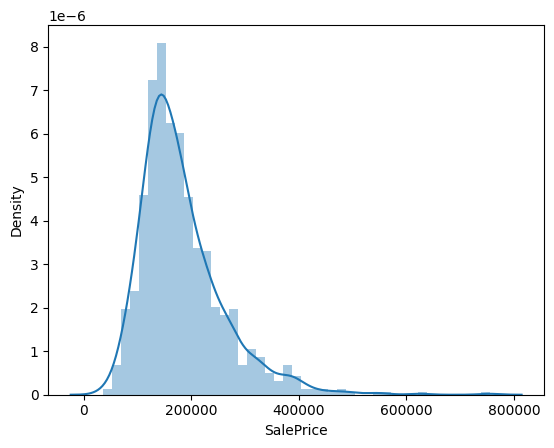

In [26]:
#Distribution of Target Variable
sns.distplot(y_train)
plt.show()

This datat is slightly right skewed. Thus a Power Transform to convert this to a Gaussian normal curve.

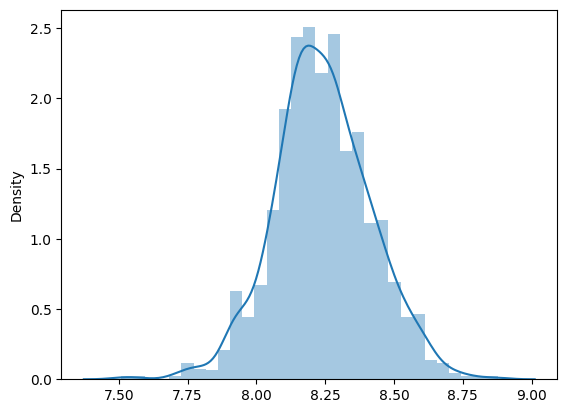

In [27]:
#Transforming the Target feature to make the data gaussian
pt = PowerTransformer(method='box-cox', standardize=False)
y_train = pt.fit_transform(y_train.to_frame())
y_test = pt.transform(y_test.to_frame())

sns.distplot(y_train)
plt.show()

Feature Scaling: <br>

Using a MinMax scaler, the features will be scaled.

In [28]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_train.columns = X.columns

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test)
X_test.columns = X.columns

In [29]:
X_train.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,1stFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,...,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_Oth,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.167808,0.082060,0.032656,0.260177,0.180651,0.285307,0.184247,0.000000,0.0,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.051370,0.204762,0.000000,0.203540,0.172945,0.189016,0.122064,0.333333,0.0,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.130137,0.085328,0.000000,0.000000,0.356164,0.177603,0.114694,0.000000,0.0,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.184932,0.125049,0.310595,0.000000,0.768408,0.521041,0.336481,0.000000,0.0,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.236301,0.159485,0.000000,0.563717,0.266267,0.574180,0.370797,0.333333,0.0,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Ridge Regression (L2 Regularization)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


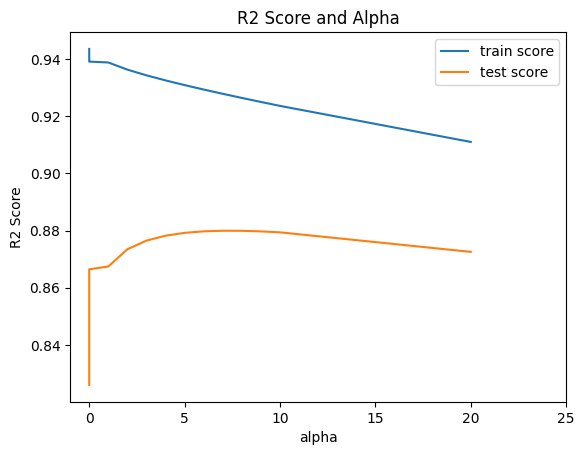

The optimum alpha is 7
The R2 Score of the model on the test dataset for optimum alpha is 0.8947901479684919
The MSE of the model on the test dataset for optimum alpha is 0.00337760692801172


In [30]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}
ridge = Ridge()

# Using RFE to find top 300 variables
rfe = RFE(estimator=Ridge(), n_features_to_select=300)
rfe = rfe.fit(X_train,y_train)
col = X_train.columns[rfe.support_]
X_train_rfe = X_train[col]
X_test_rfe = X_test[col]

# cross validation
folds = 10
model_cv = GridSearchCV(estimator = ridge, param_grid = params, scoring= 'r2', cv = folds, return_train_score=True, verbose = 1)            
model_cv.fit(X_train_rfe, y_train) 

cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=30]
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('R2 Score')
plt.title("R2 Score and Alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.xticks(np.arange(0,30,5))
plt.show()

alpha = cv_results['param_alpha'].loc[cv_results['mean_test_score'].idxmax()]
print('The optimum alpha is',alpha)
ridge_final = Ridge(alpha=alpha)
ridge_final.fit(X_train_rfe,y_train)
ridge_coef = ridge_final.coef_
y_test_pred = ridge_final.predict(X_test_rfe)
print('The R2 Score of the model on the test dataset for optimum alpha is',r2_score(y_test, y_test_pred))
print('The MSE of the model on the test dataset for optimum alpha is', mean_squared_error(y_test, y_test_pred))

In [31]:
## USing VIF to remove  features:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
high_vif = vif[vif['VIF']>10]
high_vif

,Features,VIF
203,Electrical_Mix,inf
114,OverallCond_6,inf
126,Exterior1st_CBlock,inf
117,OverallCond_9,inf
37,MSSubClass_90,inf
...,...,...
71,Neighborhood_NWAmes,10.95
163,Foundation_PConc,10.91
213,Functional_Typ,10.77
65,Neighborhood_Gilbert,10.65


In [32]:
# Even though Total Square Footage has a high VIF, it is one of the most important features to predict the cost.
tot_sq_index = high_vif.loc[high_vif.Features == "Total_sqr_footage"].index.tolist()
high_vif.drop(tot_sq_index,inplace=True)

In [33]:
# Dropping cols with high VIF value.
X_train_rfe2 = X_train_rfe.drop(high_vif.Features,axis=1)
X_test_rfe2 = X_test_rfe.drop(high_vif.Features,axis=1)

# This gives columns without Multicollinearity.

Fitting 10 folds for each of 28 candidates, totalling 280 fits


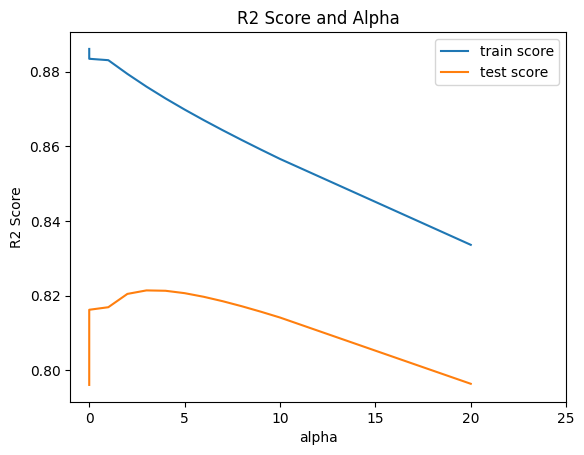

The optimum alpha is 3
The R2 Score of the model on the test dataset for optimum alpha is 0.8379661976370956
The MSE of the model on the test dataset for optimum alpha is 0.005201855937114396


In [34]:
# Building the second Ridge Model
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}
ridge = Ridge(random_state=100)

# cross validation
folds = 10
model_cv = GridSearchCV(estimator = ridge, param_grid = params, scoring= 'r2', cv = folds, return_train_score=True, verbose = 1)            
model_cv.fit(X_train_rfe2, y_train) 

cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=30]
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('R2 Score')
plt.title("R2 Score and Alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.xticks(np.arange(0,30,5))
plt.show()

alpha = cv_results['param_alpha'].loc[cv_results['mean_test_score'].idxmax()]
print('The optimum alpha is',alpha)
ridge_final2 = Ridge(alpha=alpha,random_state=100)
ridge_final2.fit(X_train_rfe2,y_train)
ridge_coef2 = ridge_final2.coef_
y_test_pred = ridge_final2.predict(X_test_rfe2)
print('The R2 Score of the model on the test dataset for optimum alpha is',r2_score(y_test, y_test_pred))
print('The MSE of the model on the test dataset for optimum alpha is', mean_squared_error(y_test, y_test_pred))

In [35]:
#Coefficients of the Model:
ridge_coeff2 = pd.DataFrame(np.atleast_2d(ridge_coef2),columns=X_train_rfe2.columns)
ridge_coeff2 = ridge_coeff2.T
ridge_coeff2.rename(columns={0: 'Ridge Co-Efficient'},inplace=True)
ridge_coeff2.sort_values(by=['Ridge Co-Efficient'], ascending=False,inplace=True)
ridge_coeff2.head(20)

,Ridge Co-Efficient
Total_sqr_footage,0.279384
TotRmsAbvGrd,0.166088
GarageCars,0.113928
GarageArea,0.113621
Fireplaces,0.096714
MasVnrArea,0.076461
SaleCondition_Partial,0.075530
LotArea,0.073585
Neighborhood_StoneBr,0.070150
Neighborhood_Crawfor,0.068255


The above features are the top 20 features likely impacting the property value.

---

## Lasso Regression (L1 Regularization)

In [36]:
# Creating a model with an arbitrary alpha to understand the value ranges
lasso1 = Lasso(alpha=0.0001)        
lasso1.fit(X_train_rfe2, y_train) 

y_test_pred = lasso1.predict(X_test_rfe2)
print('The R2 Score of the model on the test dataset for 0.0001 alpha is',r2_score(y_test, y_test_pred))
print('The MSE of the model on the test dataset for optimum alpha is', mean_squared_error(y_test, y_test_pred))

The R2 Score of the model on the test dataset for 0.0001 alpha is 0.8470378282780494
The MSE of the model on the test dataset for optimum alpha is 0.004910624632159487


Fitting 10 folds for each of 11 candidates, totalling 110 fits


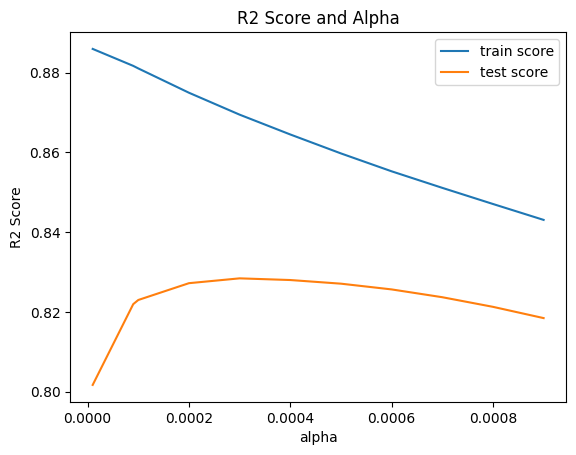

The optimum alpha is 0.0003
The R2 Score of the model on the test dataset for optimum alpha is 0.8521066600286703
The MSE of the model on the test dataset for optimum alpha is 0.004747897274338513


In [37]:
# Lasso Model with GridSearch CV to find the optimum alpha.

params = {'alpha': [0.00001, 0.00009, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009 ]}
lasso = Lasso(random_state=100)

# cross validation
folds = 10
model_cv = GridSearchCV(estimator = lasso, param_grid = params, scoring= 'r2', cv = folds, return_train_score=True, verbose = 1)            
model_cv.fit(X_train_rfe2, y_train) 

cv_results = pd.DataFrame(model_cv.cv_results_)
# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('R2 Score')
plt.title("R2 Score and Alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

alpha = cv_results['param_alpha'].loc[cv_results['mean_test_score'].idxmax()]
print('The optimum alpha is',alpha)
lasso_final2 = Lasso(alpha=alpha,random_state=100)
lasso_final2.fit(X_train_rfe2,y_train)
lasso_coef2 = lasso_final2.coef_
y_test_pred = lasso_final2.predict(X_test_rfe2)
print('The R2 Score of the model on the test dataset for optimum alpha is',r2_score(y_test, y_test_pred))
print('The MSE of the model on the test dataset for optimum alpha is', mean_squared_error(y_test, y_test_pred))

In [38]:
#Co-efficients of the model
lasso_coeff2 = pd.DataFrame(np.atleast_2d(lasso_coef2),columns=X_train_rfe2.columns)
lasso_coeff2 = lasso_coeff2.T
lasso_coeff2.rename(columns={0: "Lasso Co-Efficient"},inplace=True)
lasso_coeff2.sort_values(by=['Lasso Co-Efficient'], ascending=False,inplace=True)
lasso_coeff2.head(20)

,Lasso Co-Efficient
Total_sqr_footage,0.481359
TotRmsAbvGrd,0.156685
GarageCars,0.130103
GarageArea,0.084203
Fireplaces,0.081504
SaleCondition_Partial,0.078460
Neighborhood_Crawfor,0.063131
CentralAir_Y,0.056859
MasVnrArea,0.052245
Neighborhood_StoneBr,0.051203


The above are the top 20 features from the Lasso model that can be used to predict the price.

---

Final Ridge regression Model:

In [39]:
ridge_final2

Ridge(alpha=3, random_state=100)

Final Lasso Regression Model

In [40]:
lasso_final2

Lasso(alpha=0.0003, random_state=100)

----

## Subjective Questions Demonstration

Q1. <br>
What is the optimal value of alpha for ridge and lasso regression? <br>
What will be the changes in the model if you choose double the value of alpha for both ridge and lasso? <br>
What will be the most important predictor variables after the change is implemented?<br>

The optimal value of alpha for Ridge regression is <b>3</b> and Lasso is <b>0.0006</b>

In [41]:
# Building Ridge Model by doubling the value of alpha to 6
ridge_double = Ridge(alpha=6,random_state=seed)
ridge_double.fit(X_train_rfe2,y_train)
ridge_double_coef = ridge_double.coef_
y_test_pred = ridge_double.predict(X_test_rfe2)

print('The R2 Score of the model on the test dataset for doubled alpha is',r2_score(y_test, y_test_pred))
print('The MSE of the model on the test dataset for doubled alpha is', mean_squared_error(y_test, y_test_pred))

ridge_double_coeff = pd.DataFrame(np.atleast_2d(ridge_double_coef),columns=X_train_rfe2.columns)
ridge_double_coeff = ridge_double_coeff.T
ridge_double_coeff.rename(columns={0: 'Ridge Doubled Alpha Co-Efficient'},inplace=True)
ridge_double_coeff.sort_values(by=['Ridge Doubled Alpha Co-Efficient'], ascending=False,inplace=True)

print('\n The most important predictor variables are as follows:')
ridge_double_coeff.head(20)

The R2 Score of the model on the test dataset for doubled alpha is 0.834189661285554
The MSE of the model on the test dataset for doubled alpha is 0.005323096059579685

 The most important predictor variables are as follows:


,Ridge Doubled Alpha Co-Efficient
Total_sqr_footage,0.217854
TotRmsAbvGrd,0.155639
GarageCars,0.118477
GarageArea,0.112434
Fireplaces,0.103577
MasVnrArea,0.075150
SaleCondition_Partial,0.071627
LotArea,0.067600
Neighborhood_Crawfor,0.064019
Neighborhood_StoneBr,0.063731


In [42]:
# Building Lasso Model by doubling the value of alpha to 0.0006
lasso_double = Lasso(alpha=0.0006,random_state=seed)
lasso_double.fit(X_train_rfe2,y_train)
lasso_double_coef = lasso_double.coef_
y_test_pred = lasso_double.predict(X_test_rfe2)
print('The R2 Score of the model on the test dataset for doubled alpha is',r2_score(y_test, y_test_pred))
print('The MSE of the model on the test dataset for doubled alpha is', mean_squared_error(y_test, y_test_pred))

lasso_double_coeff = pd.DataFrame(np.atleast_2d(lasso_double_coef),columns=X_train_rfe2.columns)
lasso_double_coeff = lasso_double_coeff.T
lasso_double_coeff.rename(columns={0: 'Lasso Doubled Alpha Co-Efficient'},inplace=True)
lasso_double_coeff.sort_values(by=['Lasso Doubled Alpha Co-Efficient'], ascending=False,inplace=True)

print('\n The most important predictor variables are as follows:')
lasso_double_coeff.head(20)

The R2 Score of the model on the test dataset for doubled alpha is 0.8480605878290878
The MSE of the model on the test dataset for doubled alpha is 0.004877790447160892

 The most important predictor variables are as follows:


,Lasso Doubled Alpha Co-Efficient
Total_sqr_footage,0.475258
GarageCars,0.149792
TotRmsAbvGrd,0.149687
Fireplaces,0.088986
GarageArea,0.074501
SaleCondition_Partial,0.073487
CentralAir_Y,0.059248
Neighborhood_Crawfor,0.055009
MasVnrArea,0.037555
SaleCondition_Normal,0.035610


Q3. <br>
After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data.<br>You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now?

In [43]:
#Removing the 5 most important predictor variables from the incoming dataset
col_drop = ["Total_sqr_footage","GarageCars","TotRmsAbvGrd","Fireplaces","GarageArea"]

X_test_rfe3 = X_test_rfe2.drop(col_drop,axis=1)
X_train_rfe3 = X_train_rfe2.drop(col_drop,axis=1)

# Building Lasso Model with the new dataset
lasso3 = Lasso(alpha=0.0001,random_state=100)
lasso3.fit(X_train_rfe3,y_train)
lasso3_coef = lasso3.coef_
y_test_pred = lasso3.predict(X_test_rfe3)

print('The R2 Score of the model on the test dataset is',r2_score(y_test, y_test_pred))
print('The MSE of the model on the test dataset is', mean_squared_error(y_test, y_test_pred))

lasso3_coeff = pd.DataFrame(np.atleast_2d(lasso3_coef),columns=X_train_rfe3.columns)
lasso3_coeff = lasso3_coeff.T
lasso3_coeff.rename(columns={0: 'Lasso Co-Efficient'},inplace=True)
lasso3_coeff.sort_values(by=['Lasso Co-Efficient'], ascending=False,inplace=True)

print('\n The most important predictor variables are as follows:')
lasso3_coeff.head(5)

The R2 Score of the model on the test dataset is 0.703655275236539
The MSE of the model on the test dataset is 0.009513709753541263

 The most important predictor variables are as follows:


,Lasso Co-Efficient
LotArea,0.297323
MasVnrArea,0.249949
BedroomAbvGr,0.222297
LotFrontage,0.214203
Neighborhood_StoneBr,0.132450


------

# Conclusion: <br>

Using Lasso and Ridge Regulaziation techniques and sampling size of 75% (training data), the following are the most important features that are used to predict the price:

1. Total Square Footage
2. Total Rooms above Grade
3. Size of garage in car capacity
4. Size of garage in square feet
5. Number of fireplaces
6. Lot size in square feet
7. Neighborhood
9. Linear feet of street connected to property
9. Should have Central air conditioning
10. Type of roof